In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import json
from shapely import geometry as sgeom
import pandas as pd
import rasterio as rio

In [2]:
########## USER ###########
# Select modeling domain ('WY', 'UT', 'OR', 'WA')
domain = 'WY'

In [3]:
#CSO data path
CSOpath = 'cso-data.geojson'

#path to CSO domain json
with open('/nfs/attic/dfh/Aragon2/CSOdata/CSO_domains.json') as f:
    domains = json.load(f)

#start date    
st = domains[domain]['st']
#end date
ed = domains[domain]['ed']

#Snotel bounding box
Bbox = domains[domain]['Bbox']

# CSO projection
stn_proj = domains[domain]['stn_proj']

# CSO projection
mod_proj = domains[domain]['mod_proj']

In [4]:
#CSO observations to dataframe
gdf = gpd.read_file(CSOpath)
gdf

,id,author,depth,source,timestamp,elevation,_ms,geometry
0,00o+AQWs,Taylor Crocker,133.0,MountainHub,2018-03-03T01:34:56,857.922546,1520040896720,POINT (-149.50090 60.69244)
1,026GwtLJ,Katreen Wikstrom Jones,189.0,MountainHub,2018-03-30T22:32:03,304.133575,1522449123536,POINT (-149.18714 60.80384)
2,02Ce7B0p,Bobby Liebs,223.0,MountainHub,2017-03-19T03:16:32,820.441589,1489893392499,POINT (-145.68374 61.16554)
3,02jlNzB/,Katreen Wikstrom Jones,158.0,MountainHub,2018-03-30T22:40:13,309.560974,1522449613369,POINT (-149.18753 60.80440)
4,0+5J8p+R,Emily Baker,155.0,MountainHub,2018-12-08T22:17:33,915.523193,1544307453664,POINT (-149.42452 60.68538)
...,...,...,...,...,...,...,...,...
16423,zYi37NBt,PerOddRKHskred,400.0,regObs,2020-03-02T11:40:56,1020.210693,1583149256000,POINT (6.94020 61.30275)
16424,z++yVNkO,Krille,40.0,regObs,2016-12-15T10:00:00,440.037170,1481796000000,POINT (15.18710 67.35422)
16425,zZ1bidwh,Sigmund@obskorps,100.0,regObs,2018-12-06T16:59:00,605.781433,1544115540000,POINT (15.52934 78.17623)
16426,ZzVXZGqf,Hammerfest Kommune,3.0,regObs,2018-12-10T12:09:52,107.360275,1544443792163,POINT (23.68261 70.67978)


In [5]:
# Convert the bounding box dictionary to a shapely Polygon geometry using sgeom.box
box_sgeom = sgeom.box(Bbox['lonmin'], Bbox['latmin'], Bbox['lonmax'], Bbox['latmax'])
box_gdf = gpd.GeoDataFrame(geometry=[box_sgeom], crs=stn_proj)

In [26]:
#CSO obs within domain of interest
CSO_gdf = gpd.sjoin(gdf, box_gdf, how="inner")
CSO_gdf.drop(columns='index_right', inplace=True)
CSO_gdf.reset_index(drop=True, inplace=True)
CSO_gdf

,id,author,depth,source,timestamp,elevation,_ms,geometry
0,0MdWYWBa,Leanne,60.000000,MountainHub,2019-04-16T16:05:38,2113.166748,1555430738177,POINT (-110.60593 43.66678)
1,0O7JDkYH,Allen OBannon,105.000000,MountainHub,2018-02-11T16:26:06,2650.888672,1518366366143,POINT (-110.95347 43.50014)
2,0SE+3TJG,Tracy Jacobs,77.999997,MountainHub,2019-04-16T15:58:59,2147.359863,1555430339025,POINT (-110.59107 43.67104)
3,14ZmYkpp,Brian Warren,299.720000,MountainHub,2017-02-18T18:18:50,2550.389648,1487441930511,POINT (-110.93505 43.51346)
4,15sLCPvp,Brooks Taylor,76.000000,MountainHub,2019-01-29T20:01:51,2402.239014,1548792111499,POINT (-110.58398 43.70683)
...,...,...,...,...,...,...,...,...
570,+ZbwWnRu,Jackson Knoll,86.000000,SnowPilot,2018-12-14T18:16:00,2499.287354,1544811360000,POINT (-110.93736 43.76835)
571,zhwU93eV,jamie weeks,105.000000,SnowPilot,2017-12-18T12:54:49,2777.024658,1513601689000,POINT (-110.16819 43.81454)
572,ZieRtWwG,Mike Hardaker,220.000000,SnowPilot,2017-01-09T03:46:30,2681.205078,1483933590000,POINT (-110.94512 43.50662)
573,ZoelXlRb,Chris McCollister,132.000000,SnowPilot,2018-02-23T23:08:22,2607.050293,1519427302000,POINT (-111.14069 43.37176)


487200.0 4690100.0 625400.0 4937700.0


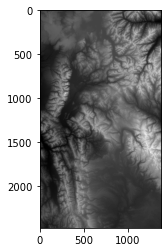

In [8]:
# dem path
dem_path = '/nfs/attic/dfh/Aragon2/CSOdmn/'+domain+'/DEM_'+domain+'.tif'
# DEM data
src = rio.open(dem_path)
bound = src.bounds
minx = bound[0]
miny = bound[1]
maxx = bound[2]
maxy = bound[3]

#with rio.open(dtm) as src:
elevation = src.read(1)

print(minx,miny,maxx,maxy)
#plot
x = plt.imshow(src.read(1), cmap='gray')
plt.show()

In [9]:
mod_proj

'epsg:32612'

In [27]:
new=CSO_gdf.to_crs(mod_proj)
new.head()

,id,author,depth,source,timestamp,elevation,_ms,geometry
0,0MdWYWBa,Leanne,60.000000,MountainHub,2019-04-16T16:05:38,2113.166748,1555430738177,POINT (531770.608 4834939.464)
1,0O7JDkYH,Allen OBannon,105.000000,MountainHub,2018-02-11T16:26:06,2650.888672,1518366366143,POINT (503761.477 4816358.165)
2,0SE+3TJG,Tracy Jacobs,77.999997,MountainHub,2019-04-16T15:58:59,2147.359863,1555430339025,POINT (532965.933 4835418.090)
3,14ZmYkpp,Brian Warren,299.720000,MountainHub,2017-02-18T18:18:50,2550.389648,1487441930511,POINT (505249.546 4817838.240)
4,15sLCPvp,Brooks Taylor,76.000000,MountainHub,2019-01-29T20:01:51,2402.239014,1548792111499,POINT (533517.987 4839395.521)


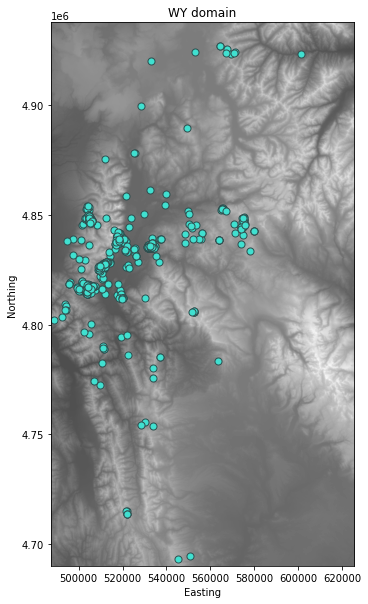

In [11]:
# plot georeferenced SnowModel output with SNOTEL stations 
fig, ax = plt.subplots(1,figsize=(8,10))

#hillshade and elevation
#ax.imshow(np.flipud(hillshade), origin = [minx,miny], extent = [minx,maxx,miny,maxy],cmap ='gray')
ax.imshow(np.flipud(elevation), origin = [minx,miny], extent = [minx,maxx,miny,maxy],cmap ='gray', alpha = 0.7)

ax.set_xlabel('Easting')
ax.set_ylabel('Northing')

# title
plt.title('WY domain')

#stations
new.plot(ax=ax,markersize=50, color='turquoise', edgecolor = 'darkslategrey')

#leg = ax.get_legend()
#leg.set_bbox_to_anchor((1,1))


#plt.savefig(f"/nfs/attic/dfh/Aragon2/Notebooks/calibration_python/figs/test.png")#Python_Animation_02_frame_{i:04}.png")
plt.show()

# Aspect

# Slope

# Landcover

In [28]:
#build list of coordinates from point geodataframe
xy = list(map(list, zip(new.geometry.x,new.geometry.y)))

In [29]:
#sample dem
with rio.open(dem_path) as src:
    CSO_gdf['dem_elev'] = [sample[0] for sample in src.sample(xy)]
CSO_gdf

,id,author,depth,source,timestamp,elevation,_ms,geometry,dem_elev
0,0MdWYWBa,Leanne,60.000000,MountainHub,2019-04-16T16:05:38,2113.166748,1555430738177,POINT (-110.60593 43.66678),2111
1,0O7JDkYH,Allen OBannon,105.000000,MountainHub,2018-02-11T16:26:06,2650.888672,1518366366143,POINT (-110.95347 43.50014),2658
2,0SE+3TJG,Tracy Jacobs,77.999997,MountainHub,2019-04-16T15:58:59,2147.359863,1555430339025,POINT (-110.59107 43.67104),2149
3,14ZmYkpp,Brian Warren,299.720000,MountainHub,2017-02-18T18:18:50,2550.389648,1487441930511,POINT (-110.93505 43.51346),2778
4,15sLCPvp,Brooks Taylor,76.000000,MountainHub,2019-01-29T20:01:51,2402.239014,1548792111499,POINT (-110.58398 43.70683),2469
...,...,...,...,...,...,...,...,...,...
570,+ZbwWnRu,Jackson Knoll,86.000000,SnowPilot,2018-12-14T18:16:00,2499.287354,1544811360000,POINT (-110.93736 43.76835),2608
571,zhwU93eV,jamie weeks,105.000000,SnowPilot,2017-12-18T12:54:49,2777.024658,1513601689000,POINT (-110.16819 43.81454),2834
572,ZieRtWwG,Mike Hardaker,220.000000,SnowPilot,2017-01-09T03:46:30,2681.205078,1483933590000,POINT (-110.94512 43.50662),2884
573,ZoelXlRb,Chris McCollister,132.000000,SnowPilot,2018-02-23T23:08:22,2607.050293,1519427302000,POINT (-111.14069 43.37176),2786


In [24]:
new.plot.scatter()

TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'

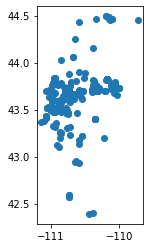

In [12]:
CSO_gdf.plot()

In [13]:

CSO_gdf['dt'] = pd.to_datetime(CSO_gdf['timestamp'], format='%Y-%m-%dT%H:%M:%S')

In [14]:
CSO_gdf['Y'] = pd.DatetimeIndex(CSO_gdf['dt']).year
CSO_gdf['M'] = pd.DatetimeIndex(CSO_gdf['dt']).month
CSO_gdf['D'] = pd.DatetimeIndex(CSO_gdf['dt']).day
CSO_gdf["LON"] = CSO_gdf.geometry.x
CSO_gdf["LAT"] = CSO_gdf.geometry.y
#convert snow depth to m
CSO_gdf['H'] = CSO_gdf.depth/100
CSO_gdf.head()

,id,author,depth,source,timestamp,elevation,_ms,geometry,dt,Y,M,D,LON,LAT,H
0,0MdWYWBa,Leanne,60.000000,MountainHub,2019-04-16T16:05:38,2113.166748,1555430738177,POINT (-110.60593 43.66678),2019-04-16 16:05:38,2019,4,16,-110.605929,43.666781,0.6000
1,0O7JDkYH,Allen OBannon,105.000000,MountainHub,2018-02-11T16:26:06,2650.888672,1518366366143,POINT (-110.95347 43.50014),2018-02-11 16:26:06,2018,2,11,-110.953472,43.500142,1.0500
2,0SE+3TJG,Tracy Jacobs,77.999997,MountainHub,2019-04-16T15:58:59,2147.359863,1555430339025,POINT (-110.59107 43.67104),2019-04-16 15:58:59,2019,4,16,-110.591073,43.671038,0.7800
3,14ZmYkpp,Brian Warren,299.720000,MountainHub,2017-02-18T18:18:50,2550.389648,1487441930511,POINT (-110.93505 43.51346),2017-02-18 18:18:50,2017,2,18,-110.935052,43.513460,2.9972
4,15sLCPvp,Brooks Taylor,76.000000,MountainHub,2019-01-29T20:01:51,2402.239014,1548792111499,POINT (-110.58398 43.70683),2019-01-29 20:01:51,2019,1,29,-110.583978,43.706826,0.7600


In [15]:
print('Total number of CSO in daimain = ',len(CSO_gdf))

Total number of CSO in daimain =  575


In [16]:
CSO_gdf = CSO_gdf.set_index(['dt'])
print('Total number of CSO in daimain within time bounds = ',len(CSO_gdf.loc[st:ed]))

Total number of CSO in daimain within time bounds =  506


In [17]:
CSO_gdf = CSO_gdf.loc[st:ed]
CSO_gdf.head()

,id,author,depth,source,timestamp,elevation,_ms,geometry,Y,M,D,LON,LAT,H
dt,,,,,,,,,,,,,,
2019-04-16 16:05:38,0MdWYWBa,Leanne,60.000000,MountainHub,2019-04-16T16:05:38,2113.166748,1555430738177,POINT (-110.60593 43.66678),2019,4,16,-110.605929,43.666781,0.6000
2018-02-11 16:26:06,0O7JDkYH,Allen OBannon,105.000000,MountainHub,2018-02-11T16:26:06,2650.888672,1518366366143,POINT (-110.95347 43.50014),2018,2,11,-110.953472,43.500142,1.0500
2019-04-16 15:58:59,0SE+3TJG,Tracy Jacobs,77.999997,MountainHub,2019-04-16T15:58:59,2147.359863,1555430339025,POINT (-110.59107 43.67104),2019,4,16,-110.591073,43.671038,0.7800
2017-02-18 18:18:50,14ZmYkpp,Brian Warren,299.720000,MountainHub,2017-02-18T18:18:50,2550.389648,1487441930511,POINT (-110.93505 43.51346),2017,2,18,-110.935052,43.513460,2.9972
2019-01-29 20:01:51,15sLCPvp,Brooks Taylor,76.000000,MountainHub,2019-01-29T20:01:51,2402.239014,1548792111499,POINT (-110.58398 43.70683),2019,1,29,-110.583978,43.706826,0.7600


# Hs to SWE

In [18]:
from Depth2SWE import swe_calc

In [19]:
SWE,DOY = swe_calc(CSO_gdf.Y.values,CSO_gdf.M.values,CSO_gdf.D.values,
                   CSO_gdf.H.values,CSO_gdf.LAT.values,CSO_gdf.LON.values)

KeyboardInterrupt: 

In [ ]:
CSO_gdf['SWE'] = SWE
CSO_gdf['DOY'] = DOY
CSO_gdf.head()

## QC observations 

* 

## Organize data by various methods

* Aspect
* Elevation
* Timing
* Look up ideal temporal spatial analysis 
* Landcover class

vs random sampling 

In [15]:
#change projection 
CSO_gdf=CSO_gdf.to_crs(mod_proj)
CSO_gdf.head()

,id,author,depth,source,timestamp,elevation,_ms,geometry
dt,,,,,,,,
2020-01-05 20:04:08,0FIbt71c,Bob Sutherland,61.999998,MountainHub,2020-01-05T20:04:08,980.924622,1578254648880,POINT (682980.206 5385303.004)
2020-01-14 19:57:54,0T3SEQNz,Yasmine Hentati,27.000000,MountainHub,2020-01-14T19:57:54,1051.207520,1579031874034,POINT (711127.879 5354320.304)
2019-01-05 20:44:26,1OaGvegg,Bob Sutherland,60.959999,MountainHub,2019-01-05T20:44:26,1155.734619,1546721066939,POINT (697328.389 5384562.328)
2020-01-30 19:48:48,1xmy9hHt,Bob Sutherland,109.999996,MountainHub,2020-01-30T19:48:48,900.381226,1580413728183,POINT (679288.022 5391342.888)
2020-01-03 16:58:12,20OQ9cvy,David Hill,35.000000,MountainHub,2020-01-03T16:58:12,1234.039551,1578070692193,POINT (699569.628 5382743.595)


In [ ]:
#snow depth to swe 

# need to develop a way to QC the CSO data and create assimilation ensebles 

In [ ]:
# print as file for SM

In [19]:
import Depth2SWE

AttributeError: 'NoneType' object has no attribute 'ReadAsArray'